# Importing libraries

In [1]:
import numpy as np
import pysindy as ps
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit 
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Data Processing

In [2]:
df = pd.read_csv("DNS_Data_PySINDy.csv")
# Select the specific DataFrame columns needed for PySINDy or PINNs
df = df[["y^+","U","Re_tau","u'u'","v'v'","w'w'","u'v'","P","dU/dy"]]
Reynolds_Number = df["Re_tau"].unique() # Obtain the different Reynolds numbers
df

,y^+,U,Re_tau,u'u',v'v',w'w',u'v',P,dU/dy
0,0.000000,0.000000,5185.897,4.176503e-36,0.000000,-4.685007e-10,0.000000,0.000000,1.000000
1,0.518124,0.518066,5185.897,5.631775e-02,0.000016,2.217542e-02,-0.000197,-0.000016,0.999702
2,1.036249,1.035755,5185.897,2.146491e-01,0.000173,7.611461e-02,-0.001431,-0.000173,0.998367
3,1.554373,1.552302,5185.897,4.703307e-01,0.000694,1.508211e-01,-0.004692,-0.000695,0.995003
4,2.072498,2.066162,5185.897,8.257437e-01,0.001886,2.396174e-01,-0.011195,-0.001888,0.988395
...,...,...,...,...,...,...,...,...,...
49995,180.486137,18.268216,182.088,6.365826e-01,0.378819,3.800729e-01,-0.008124,-0.378819,0.000670
49996,180.504194,18.268239,182.088,6.365619e-01,0.378816,3.800658e-01,-0.008032,-0.378816,0.000662
49997,180.522252,18.268262,182.088,6.365412e-01,0.378813,3.800587e-01,-0.007940,-0.378813,0.000655
49998,180.540310,18.268285,182.088,6.365206e-01,0.378809,3.800516e-01,-0.007849,-0.378809,0.000647


             y^+         U    Re_tau      u'u'      v'v'      w'w'      u'v'  \
y^+     1.000000  0.738984  0.776980 -0.340610 -0.145683 -0.306551  0.384455   
U       0.738984  1.000000  0.621793 -0.516401  0.080846 -0.283004  0.325131   
Re_tau  0.776980  0.621793  1.000000  0.071721  0.305527  0.184946 -0.080170   
u'u'   -0.340610 -0.516401  0.071721  1.000000  0.488586  0.825218 -0.802339   
v'v'   -0.145683  0.080846  0.305527  0.488586  1.000000  0.869458 -0.862191   
w'w'   -0.306551 -0.283004  0.184946  0.825218  0.869458  1.000000 -0.955422   
u'v'    0.384455  0.325131 -0.080170 -0.802339 -0.862191 -0.955422  1.000000   
P       0.142508 -0.083107 -0.309404 -0.488244 -0.999988 -0.869026  0.861660   
dU/dy  -0.202809 -0.694136 -0.183606  0.302319 -0.391446 -0.067394  0.070299   

               P     dU/dy  
y^+     0.142508 -0.202809  
U      -0.083107 -0.694136  
Re_tau -0.309404 -0.183606  
u'u'   -0.488244  0.302319  
v'v'   -0.999988 -0.391446  
w'w'   -0.869026 -0.06739

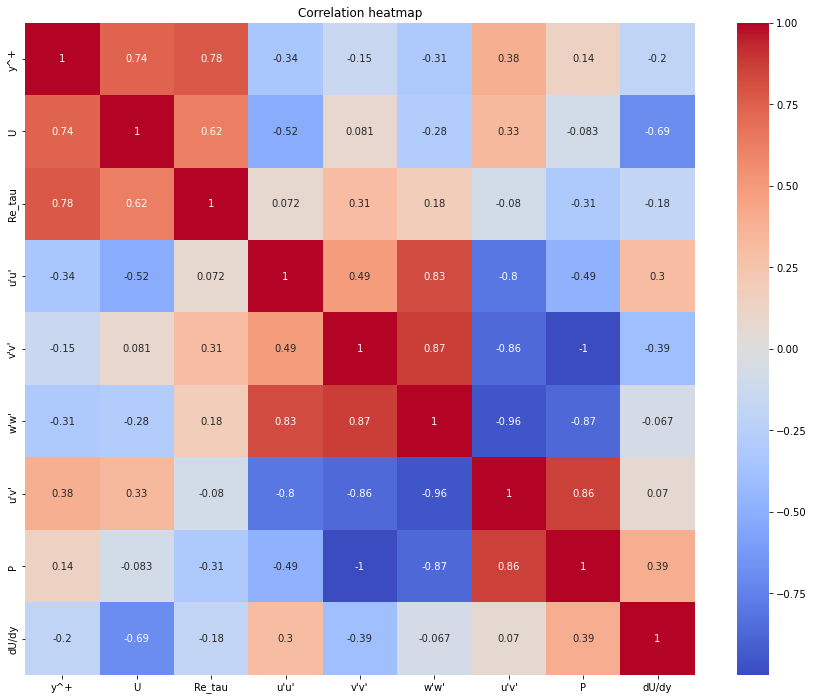

In [3]:
# Calculate the correlation matrix for the DataFrame and display it in the form of a heatmap
corr = df.corr()
print(corr)
plt.figure(figsize=(15,12))
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Correlation heatmap")
plt.show()

In [4]:
def first_derivative(columns,df):
    """
    Compute the first derivative of the specified columns.
    
    Args:
        columns (list): List of column names in the dataframe for which the first derivative is to be calculated
        df (pd.DataFrame): The dataframe containing the DNS data
       
    Returns:
        pd.DataFrame: The input dataframe with the additional columns representing the first derivative 
        of the columns present in the list (columns)
    """
    for col in columns:  
        # Extract the data from a column and y^+ into numpy arrays
        x = df[col].to_numpy()
        y = df["y^+"].to_numpy()
        
        # Calculate the first derivative of the column with respect to y^+
        dx = np.gradient(x,y)
        
        # Store the result of the first derivative of the column in the dataframe
        df["d" + col + "/dy"] = dx
        
    return df

def second_derivative(columns,df):
    """
    Compute the second derivative of the specified columns.
    
    Args:
        columns (list): List of column names in the dataframe for which the second derivative is to be calculated
        df (pd.DataFrame): The dataframe containing the DNS data
       
    Returns:
        pd.DataFrame: The input dataframe with the additional columns representing the second derivative 
        of the columns present in the list (columns)
    """
    for col in columns: 
        # Extract the data from a column and y^+ into numpy arrays
        x = df[col].to_numpy()
        y = df["y^+"].to_numpy()
        
        # Calculate the first derivative of the column with respect to y^+
        dx = np.gradient(x,y)
        
        # Store the result of the first derivative of the column in the dataframe
        df["d(" + col + ")/dy"] = dx
        
    return df

def data_processing(df, Reynolds_Number):
    """
    Process the dataframe to have the first and second derivative.
    
    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        Reynolds_Numbers (list): The list of Reynolds numbers
    
    Returns:
        dict: The processed data
    """
    
    # Dictionary containing dataframes associated with a specific number of reynolds
    data = {f'df_{Re}': df[df["Re_tau"] == Re] for Re in Reynolds_Number}
    
    # Calculate the first and second derivatives of the specified columns for each dataframe in the dictionary
    for Re in Reynolds_Number:
        
        columns_to_derive = ["u'u'", "v'v'", "w'w'", "u'v'","P"]
        data[f"df_{Re}"] = first_derivative(columns_to_derive,data[f"df_{Re}"])
        
        columns_to_derive = ["dU/dy","du'u'/dy", "dv'v'/dy", "dw'w'/dy", "du'v'/dy","dP/dy"]
        data[f"df_{Re}"] = second_derivative(columns_to_derive,data[f"df_{Re}"])
        
    return data

In [5]:
data = data_processing(df,Reynolds_Number)

C:\Users\moi\AppData\Local\Temp/ipykernel_203996/2232888765.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d" + col + "/dy"] = dx
C:\Users\moi\AppData\Local\Temp/ipykernel_203996/2232888765.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["d(" + col + ")/dy"] = dx


In [6]:
def data_PySINDy(data,Reynolds_Number):
    """
    Prepare the data for PySINDy
   
    Args:
        data (dict): The processed data
        Reynolds_Numbers (list): The list of Reynolds numbers
    
    Returns:
        list: The input data (containing the feature variables)
        list: The output data (containing the target variables)
    """
    # Initialise the lists containing the feature variables (X) and target variables (y) for each Reynolds number
    X = [[] for _ in range(len(Reynolds_Number))]
    y = [[] for _ in range(len(Reynolds_Number))]
    
    for i in range(0,len(Reynolds_Number)):
        # Extract the feature variables 
        X[i] = data[f"df_{Reynolds_Number[i]}"].drop(columns=["y^+","Re_tau","d(dU/dy)/dy","d(du'u'/dy)/dy", "d(dv'v'/dy)/dy", "d(dw'w'/dy)/dy", "d(du'v'/dy)/dy","d(dP/dy)/dy"]).values
        
        # Extract the target variables 
        y[i] = data[f"df_{Reynolds_Number[i]}"][["dU/dy", "du'u'/dy", "dv'v'/dy", "dw'w'/dy", "du'v'/dy","dP/dy","d(dU/dy)/dy","d(du'u'/dy)/dy", "d(dv'v'/dy)/dy", "d(dw'w'/dy)/dy", "d(du'v'/dy)/dy","d(dP/dy)/dy"]].values
    
    return X,y

In [7]:
X,y = data_PySINDy(data,Reynolds_Number)

# PySINDy Model

In [8]:
# Select the DNS data of the Reynolds Number 5200 for the training data and the DNS data of the Reynolds Number 2000 for the test data.
X_train = X[0]
y_train = y[0]
X_test = X[1]
y_test = y[1]

### GridSearch Algorithm

In [9]:
# Initialise the variables to store the best score and the corresponding parameters
best_score = -np.inf
best_params = {}

# Define the feature libraries and other parameters for the grid search algorithm
Features_Library_gs = ["PolynomialLibrary1","PolynomialLibrary2","FourierLibrary"]
alphas = [0.1,0.01,0.001]
thresholds = [0.01,0.001,0.0001]

# Iterate for each possible combination of threshold, alpha coefficient and feature_library
for features in Features_Library_gs:
    for threshold in thresholds:
        for alpha in alphas:
            
            # Set the optimiser with the current parameters (threshold and alpha coefficient)
            optimizer = ps.STLSQ(threshold=threshold, alpha=alpha)
            
            # Set the feature_library with the current parameters 
            if features == "PolynomialLibrary1":
                feature_library = ps.PolynomialLibrary(degree=1)
            elif features == "PolynomialLibrary2":
                feature_library = ps.PolynomialLibrary(degree=2)
            elif features == "FourierLibrary":
                feature_library = ps.FourierLibrary()
            
            # Create the SYNDy model with the selected parameters 
            model = ps.SINDy(optimizer=optimizer, feature_library=feature_library)
            
            # Fit the model on training data
            model.fit(X_train, x_dot=y_train)
            
            # Calculate the score of the trained model on the test data
            score = model.score(X_test, x_dot=y_test)  
            
            # Update the score and parameters if the current score is higher than the previous score
            if score > best_score:
                best_score = score
                best_params = {"FeatureLibrary": features}
                
print("Optimal hyperparameters:", best_params)

C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and elimina

C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and elimina

C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and eliminated all coefficients
  warnings.warn(
C:\Users\moi\anaconda3\lib\site-packages\pysindy\optimizers\stlsq.py:201: UserWarning: Sparsity parameter is too big (0.01) and elimina

Optimal hyperparameters: {'FeatureLibrary': 'PolynomialLibrary1'}


### Training of the PySINDy Model

In [10]:
# Define the names of the elements that are going to be used in the model
feature_names = ["U","u'u'", "v'v'", "w'w'", "u'v'","P","dU/dy", "du'u'/dy", "dv'v'/dy", "dw'w'/dy", "du'v'/dy","dP/dy"]

# Set the feature_library parameter
feature_library = ps.PolynomialLibrary(1)

print("\n*********************************")
print(f"Reynolds Number = {Reynolds_Number[0]}")
print("PysINDy Model:")

# Define the STLSQ optimizer and its parameters
optimizer = ps.STLSQ(threshold=0.001,alpha=0.0001)

# Create the SYNDy model with the specified parameters 
model = ps.SINDy(feature_library=feature_library,optimizer=optimizer,feature_names=feature_names)

# Fit the model on the training data
model.fit(X_train,x_dot = y_train)

# Display the equations of the PySINDY model
model.print()


*********************************
Reynolds Number = 5185.897
PysINDy Model:
(U)' = 1.000 dU/dy
(u'u')' = 1.000 du'u'/dy
(v'v')' = 1.000 dv'v'/dy
(w'w')' = 1.000 dw'w'/dy
(u'v')' = 1.000 du'v'/dy
(P)' = 1.000 dP/dy
(dU/dy)' = 0.010 v'v' + 0.011 P + -10.800 dv'v'/dy + 0.999 du'v'/dy + -10.787 dP/dy
(du'u'/dy)' = -0.096 1 + 0.003 U + -0.008 u'u' + 0.753 v'v' + 0.039 w'w' + -0.002 u'v' + 0.765 P + 0.230 dU/dy + -0.217 du'u'/dy + -0.242 dv'v'/dy + 2.519 dw'w'/dy + 6.150 du'v'/dy + 1.270 dP/dy
(dv'v'/dy)' = 0.004 v'v' + 0.004 P + 1.023 dv'v'/dy + 0.015 dw'w'/dy + -0.046 du'v'/dy + 1.090 dP/dy
(dw'w'/dy)' = -0.061 v'v' + -0.061 P + 0.079 dU/dy + -0.056 du'u'/dy + -7.455 dv'v'/dy + 0.024 dw'w'/dy + 0.191 du'v'/dy + -6.780 dP/dy
(du'v'/dy)' = -0.008 v'v' + -0.008 P + 0.002 dU/dy + -0.021 du'u'/dy + 3.477 dv'v'/dy + -0.030 dw'w'/dy + -0.379 du'v'/dy + 3.624 dP/dy
(dP/dy)' = -0.005 v'v' + -0.004 P + -1.026 dv'v'/dy + -0.015 dw'w'/dy + 0.046 du'v'/dy + -1.092 dP/dy


### Evaluation of the PySINDy Model

In [11]:
# Use the model to predict values based on the test features
y_pred = model.predict(X_test)
y_true = y_test

# Compute the R-squared value
r2 = r2_score(y_true, y_pred)
print(f"R-square: {r2}")

# Compute the MSE value
mse = mean_squared_error(y_true, y_pred)
print(f"MSE: {mse}")

R-square: 0.9068654467055067
MSE: 4.55985611851965e-06


In [12]:
def test_overfitting(X_train,y_train,X_test,y_test,model):
    """
    Test if the model is overfitting.
    
    Args:
        X_train (list): The input training data
        y_train (list): The output training data
        X_test (list): The input testing data
        y_test (list): The output testing data
        model (dict): The PySINDy model

    Returns:
        None
    """
    
    # Use the model to predict values based on the train features
    y_train_pred =  model.predict(X_train)
    # Compute the train MSE value
    mse_train = mean_squared_error(y_train, y_train_pred)
    
    # Use the model to predict values based on the train features
    y_test_pred =  model.predict(X_test)
    # Compute the test MSE value
    mse_test = mean_squared_error(y_test, y_test_pred)
    
    print(f"MSE Training: {mse_train}")
    print(f"MSE Test: {mse_test}")
    
    # Check that there is no overfitting by comparing the training and test MSEs
    if abs(mse_train - mse_test) > 0.001:
        print("PySINDy Model - Overfitting!")
    else:
         print("PySINDy Model - No Overfitting!")

In [13]:
test_overfitting(X_train,y_train,X_test,y_test,model)

MSE Training: 4.083522412073452e-08
MSE Test: 4.55985611851965e-06
PySINDy Model - No Overfitting!


### PySINDy Simulation

In [14]:
def integrate(y_plus, y, coeffs):    
    """
    Computes the derivatives at a point for integration.

    Args:
        y_plus (float): The spatial variable for the integration
        y (array): Current state variables
        coeffs (array): Coefficients of the trained PySINDy Model

    Returns:
        list: Derivatives of the state variables and their second derivatives
    """
    
    # Initialise a variable to store the derivatives
    derivatives = []
    
    # Calculate the derivative for each state variable using the coefficients of the trained PySINDy Model
    for i in range(len(y)):
        dd = coeffs[i][0] + np.dot(coeffs[i][1:], y) 
        derivatives.append(dd)
    
    return derivatives


def simulation(X, df, model):
    """
    Simulate the PySINDy model using numerical integration.
    
    Args:
        X (list): The input data
        df (pd.DataFrame): The dataframe containing the DNS data
        model (object): The trained PySINDy Model
        
    Returns:
        OdeResult: The result of the simulation
    """
    
    # Extract the initial conditions 
    initial_conditions = X[0]
    
    # Extract the coefficients of the PySINDy Model
    coeffs = model.optimizer.coef_
    
    # Extract the y^+ values of the dataframe
    y_plus_points = df["y^+"].values
    
    # Run the integration over the range of y^+ points
    solution = solve_ivp(
        fun=integrate, 
        t_span=(y_plus_points.min(), y_plus_points.max()), 
        y0=initial_conditions, 
        args=(coeffs,), 
        t_eval=y_plus_points,  
        method='RK45',
        dense_output = True
    )
    
    return solution

In [15]:
#Simulate the PySINDy model for DNS data associated with the Reynolds number 2000
solution = simulation(X_test, data["df_1994.756"], model)

In [16]:
def simulation_plot(df, solution):
    """
    Plot the simulation
    
    Args:
        df (pd.DataFrame): The dataframe containing the DNS data
        solution (scipy.integrate._ivp.ivp.OdeSolution): The solutions of the PySINDy Simulation

    Returns:
        None
    """
    col = ["U","u'u'","v'v'","w'w'","u'v'"]
    
    for i in range(5):
        
        plt.figure(figsize=(12, 6))
        
        # Extract the y^+ values of the dataframe
        y = df['y^+'].values
        
        subset_pred = solution.y[i]
        subset_target = df[col[i]]
        
        if col[i] == "u'v'":
            subset_pred = -1*solution.y[i] 
            subset_target = -1 * df[col[i]]
        
        # Plot predictions and DNS data
        plt.plot(solution.t, subset_pred,color="blue",linestyle="-",label = f"{col[i]} (PySINDy)")
        plt.plot(y, subset_target.values, color="red",linestyle="--",label=f"{col[i]} (DNS)")
        
        plt.xscale('log')
        plt.xlim(left=0.1, right = 10000)
        plt.xlabel('y^+')
        
        if col[i] == "u'v'":
            plt.ylabel(f"- {col[i]}")
            plt.title(f"- {col[i]} Prediction vs. DNS")
        else:
            plt.ylabel(col[i])
            plt.title(f"{col[i]} Prediction vs. DNS")
        
        plt.legend()
        plt.plot()

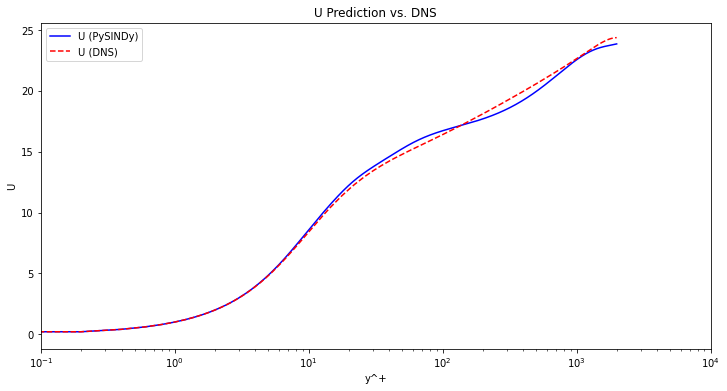

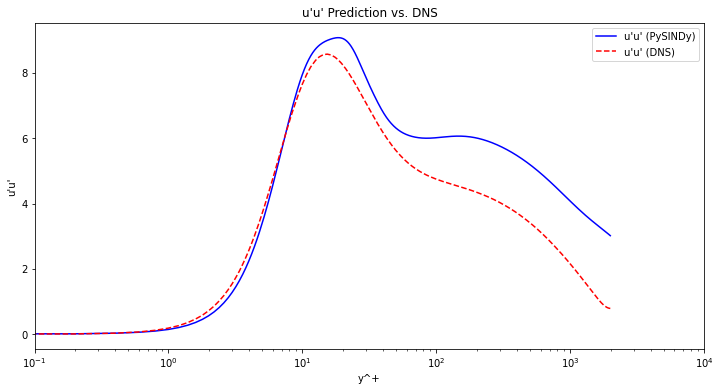

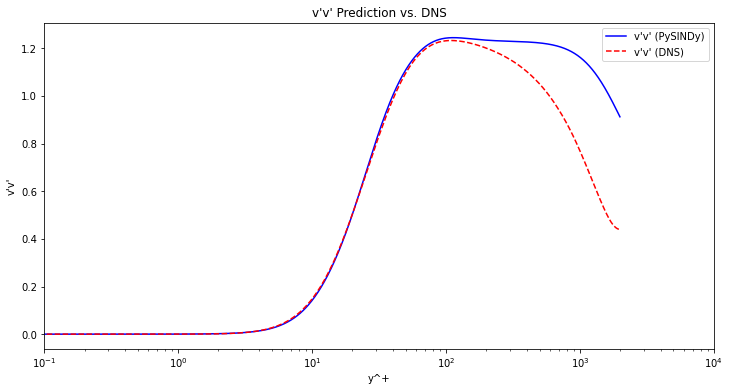

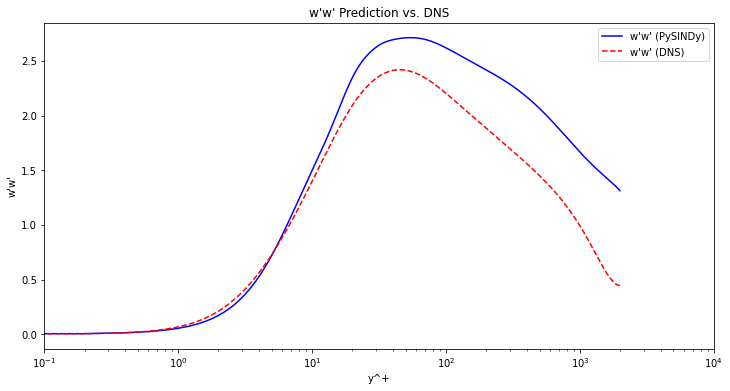

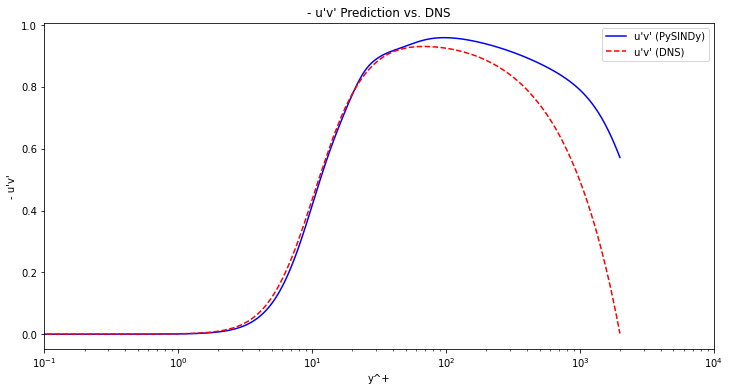

In [17]:
simulation_plot(data["df_1994.756"], solution)

In [18]:
# Create a dataframe from the simulation results
df_sim = pd.DataFrame({"y^+":solution.t,'U': solution.y[0], "u'u'": solution.y[1], "v'v'": solution.y[2], "w'w'": solution.y[3], "u'v'": solution.y[4]})

# Compute the MAE between simulation results and DNS data 
mae_sim = mean_absolute_error( data["df_1994.756"][["U","u'u'","v'v'","w'w'","u'v'"]].values,df_sim[["U","u'u'","v'v'","w'w'","u'v'"]].values)
print(f"MAE: {mae_sim}")

MAE: 0.7189373423819994


In [19]:
df_sim.to_csv("prediction_output_pysindy.csv",index=False)

# GA

In [20]:
from deap import base, creator, tools, algorithms
from copy import deepcopy
import time

begin = time.time()

def cost_function(coeffs):
    """
    Evaluate the performance of the PySINDy model with given coefficients.

    Args:
        coeffs (list): A list of coefficients for the PySINDy Model.

    Returns:
        tuple: A tuple containing only the MSE
    """
    # Update the PySINDy model with the new coefficients
    new_model = deepcopy(model)
    new_model.optimizer.coef_ = np.array(coeffs).reshape(model.optimizer.coef_.shape)
    
    # Making predictions with the new model
    y_pred = new_model.predict(X_test)
    
    # Compute the MSE
    cost = mean_squared_error(y_test, y_pred)
    
    return (cost,)

# Configuring the genetic algorithm with DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

# Define how the attributes of individuals (coefficients) are chosen
coeffs = model.optimizer.coef_
coeffs = coeffs.flatten()
toolbox.register("attr_float", np.random.uniform, -1, 1)  
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=len(coeffs))
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


# Register genetic operations: evaluation, mating, mutation and selection
toolbox.register("evaluate", cost_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Generate the initial population
population = toolbox.population(n=2000)

#Preparing the HallOfFame to store the best individual
hof = tools.HallOfFame(1, similar=np.array_equal)

# Track progress with metrics
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)

# Run the GA
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)


end = time.time()

# Best coefficients after optimisation
best_coeffs = hof[0]

print(f"The best coefficients are : {best_coeffs}")   

print(f"GA - execution time : {end - begin} seconds")


gen	nevals	min    	avg    
0  	2000  	55.2132	165.897
1  	1250  	23.5435	162.505
2  	1145  	23.5435	139.679
3  	1225  	17.3222	123.983
4  	1191  	20.5724	105.136
5  	1153  	15.4901	88.281 
6  	1155  	12.6987	78.6571
7  	1213  	8.2711 	67.2686
8  	1231  	6.7531 	59.0483
9  	1168  	6.7531 	52.5752
10 	1246  	6.59001	50.7156
11 	1202  	6.07253	46.0475
12 	1166  	5.78497	44.2495
13 	1177  	4.62339	38.0664
14 	1175  	3.613  	36.2102
15 	1194  	4.24039	35.8923
16 	1229  	3.77316	35.809 
17 	1189  	3.70173	32.6349
18 	1205  	2.44383	35.1031
19 	1168  	2.44383	33.322 
20 	1194  	2.44383	29.9685
21 	1253  	2.44383	28.1276
22 	1245  	1.97168	31.0209
23 	1261  	2.24095	28.3143
24 	1178  	2.24095	29.6106
25 	1204  	2.24095	27.8626
26 	1217  	1.92979	28.2733
27 	1201  	1.92979	24.278 
28 	1211  	1.92979	26.1273
29 	1198  	1.92979	28.0917
30 	1145  	1.81954	24.2127
31 	1192  	1.69738	27.5453
32 	1221  	1.69738	25.3072
33 	1133  	1.69738	25.2612
34 	1196  	1.51656	25.8052
35 	1218  	1.37048	26.2628
3

In [21]:
# Update the coefficients of the PySINDy model with the optimised coefficients determined by the GA
new_coeffs = np.array(best_coeffs).reshape((12,13))
model.optimizer.coef_ = new_coeffs
print("PySINDy Model:")
model.print()

PySINDy Model:
(U)' = -0.093 1 + -0.038 U + 0.286 u'u' + 0.022 v'v' + 0.124 w'w' + -1.810 u'v' + 1.636 P + -0.325 dU/dy + 5.268 du'u'/dy + -1.815 dv'v'/dy + 0.049 dw'w'/dy + 0.326 du'v'/dy + 1.043 dP/dy
(u'u')' = 1.101 1 + 0.037 U + 0.269 u'u' + 0.403 v'v' + -1.875 w'w' + 0.291 u'v' + 0.933 P + 4.105 dU/dy + -0.104 du'u'/dy + -0.322 dv'v'/dy + 0.073 dw'w'/dy + -0.338 du'v'/dy + 0.217 dP/dy
(v'v')' = -0.474 1 + 0.056 U + 0.144 u'u' + -0.398 v'v' + -0.878 w'w' + -0.926 u'v' + -0.433 P + -3.591 dU/dy + 0.144 du'u'/dy + 0.013 dv'v'/dy + -0.987 dw'w'/dy + 1.076 du'v'/dy + -0.373 dP/dy
(w'w')' = -0.288 1 + 0.079 U + -0.067 u'u' + -0.466 v'v' + -0.754 w'w' + 0.267 u'v' + -0.083 P + -1.679 dU/dy + -0.661 du'u'/dy + 0.744 dv'v'/dy + -2.097 dw'w'/dy + -0.053 du'v'/dy + -7.845 dP/dy
(u'v')' = -1.567 1 + 0.174 U + -0.144 u'u' + -0.275 v'v' + -0.592 w'w' + 1.275 u'v' + 0.252 P + 1.772 dU/dy + -0.190 du'u'/dy + 0.096 dv'v'/dy + -0.072 dw'w'/dy + 1.780 du'v'/dy + -0.484 dP/dy
(P)' = -0.083 1 + 0.052 

In [22]:
#Simulate the PySINDy model optimised by the GA for DNS data associated with Reynolds number 2000
solution_GA = simulation(X_test, data["df_1994.756"], model)

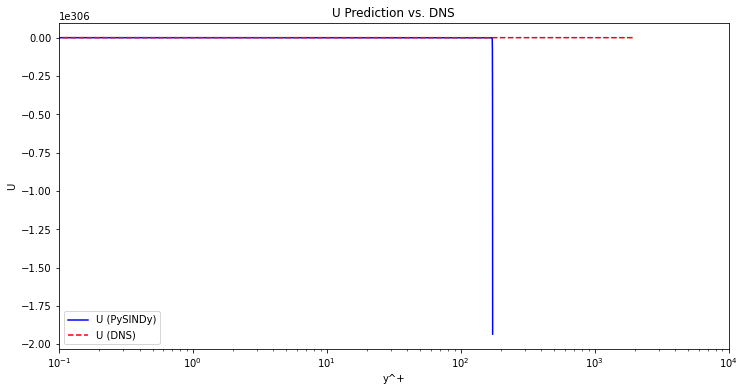

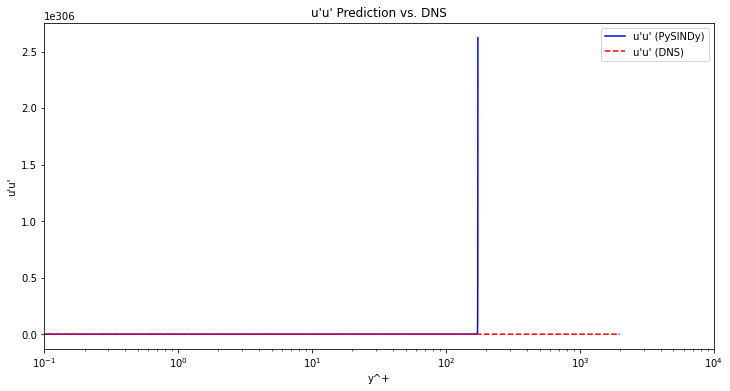

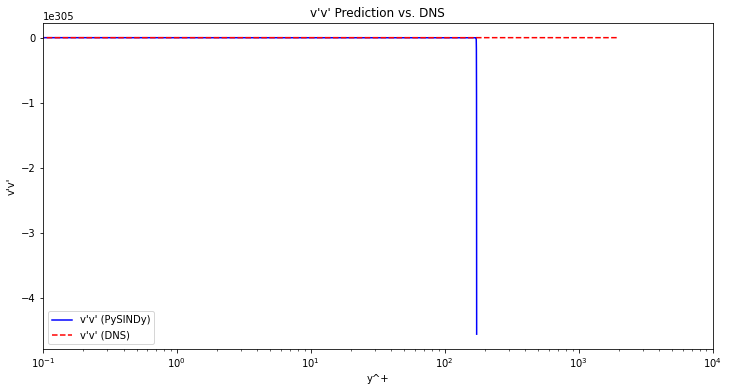

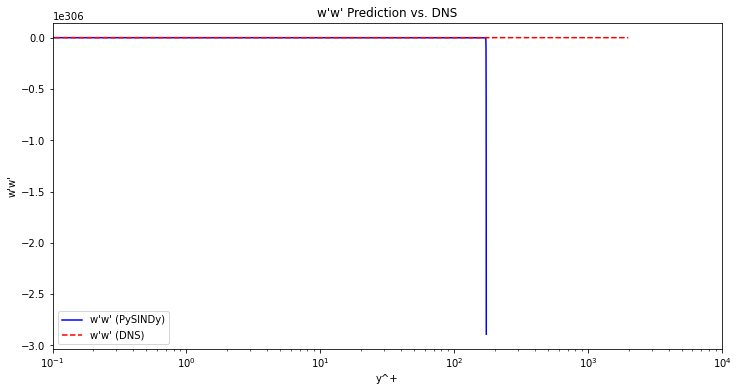

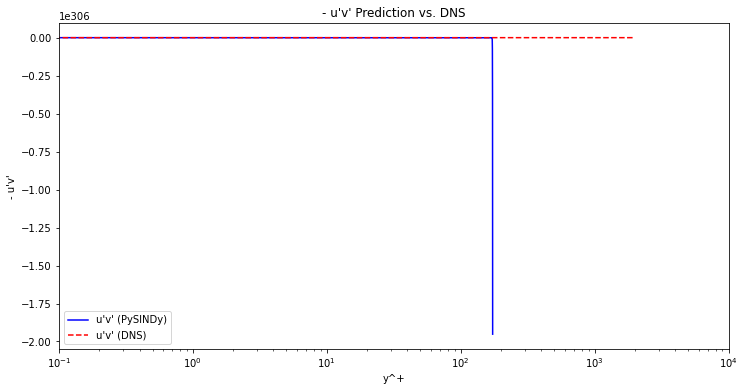

In [23]:
simulation_plot(data["df_1994.756"], solution_GA)

In [24]:
# Create a dataframe from the simulation results
df_sim_GA = pd.DataFrame({"y^+":solution_GA.t,'U': solution_GA.y[0], "u'u'": solution_GA.y[1], "v'v'": solution_GA.y[2], "w'w'": solution_GA.y[3], "u'v'": solution_GA.y[4]})
df_pred = data["df_1994.756"][data["df_1994.756"]['y^+'].isin(solution_GA.t)]
# Compute the MAE between simulation results and DNS data 
mae_sim_GA = mean_absolute_error(df_pred[["U","u'u'","v'v'","w'w'","u'v'"]].values,df_sim_GA[["U","u'u'","v'v'","w'w'","u'v'"]].values)
print(f"MAE: {mae_sim_GA}")

MAE: 4.068499247113758e+303


In [25]:
df_sim_GA.to_csv("prediction_output_pysindy_ga.csv",index=False)